In [2]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
import nibabel as nib
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm.notebook import tqdm  # Import tqdm for notebooks
import pickle
from grakel import GraphKernel

In [3]:
def load_fc_matrix(file_path):
    """ Load functional connectivity matrix from a .pconn.nii file. """
    img = nib.load(file_path)
    fc_matrix = img.get_fdata()
    return fc_matrix

def create_knn_graph(fc_matrix, k=5):
    """ Create a graph from a functional connectivity matrix using k-nearest neighbors based on absolute values. """
    n = fc_matrix.shape[0]  # Number of nodes
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    
    # For each node, add edges to the k-nearest neighbors based on absolute values of connectivity strengths
    for i in range(n):
        # Sort indices based on the absolute values, get the k highest values indices for each row
        indices = np.argsort(np.abs(fc_matrix[i]))[-k:]
        for j in indices:
            if i != j:  # Ensure no self-loops
                G.add_edge(i, j, weight=fc_matrix[i][j])
    
    return G
def create_threshold_graph(fc_matrix, std_multiplier=2):
    """
    Create a graph from a functional connectivity matrix by adding edges where the 
    absolute connection strength is above a threshold defined as a multiple of the
    standard deviation of the absolute values in the connectivity matrix.
    """
    n = fc_matrix.shape[0]  # Number of nodes
    G = nx.Graph()
    
    # Calculate the threshold as std_multiplier times the standard deviation of the absolute values
    threshold = std_multiplier * np.std(np.abs(fc_matrix))
    
    # Add nodes
    for i in range(n):
        G.add_node(i)
    
    # Add edges based on the threshold
    for i in range(n):
        for j in range(n):
            if i != j and np.abs(fc_matrix[i, j]) > threshold:  # Avoid self-loops and check threshold
                G.add_edge(i, j, weight=fc_matrix[i, j])
    
    return G

In [13]:
# Precompute features for each graph
def precompute_features(graph):
    if not nx.is_connected(graph):
        largest_cc = max(nx.connected_components(graph), key=len)
        graph = graph.subgraph(largest_cc).copy()
    
    N = len(graph.nodes)
    if N == 1:
        nnd = 0
        mu = 0
    else:
        d = nx.diameter(graph)
        distance_distribution = np.zeros(d + 1)
        
        for node in graph.nodes:
            lengths = nx.single_source_shortest_path_length(graph, node)
            for length in lengths.values():
                if length <= d:
                    distance_distribution[length] += 1
        
        distance_distribution /= (N * (N - 1))
        distance_distribution = np.clip(distance_distribution, 1e-10, None)  # Avoid log(0)
        nnd = np.sum(distance_distribution * np.log(1 / distance_distribution)) / np.log(d + 1)
        mu = np.mean([len(nx.single_source_shortest_path_length(graph, source=i)) - 1 for i in graph.nodes])
    
    degrees = [degree for node, degree in graph.degree()]
    hist, _ = np.histogram(degrees, bins=range(1, max(degrees) + 2), density=True)
    degree_dist = hist
    
    graph_complement = nx.complement(graph)
    degrees_c = [degree for node, degree in graph_complement.degree()]
    hist_c, _ = np.histogram(degrees_c, bins=range(1, max(degrees_c) + 2), density=True)
    degree_dist_c = hist_c
    
    return {
        'nnd': nnd,
        'mu': mu,
        'degree_dist': degree_dist,
        'degree_dist_c': degree_dist_c
    }

# Pad distributions to the same length
def pad_distributions(dist1, dist2):
    max_length = max(len(dist1), len(dist2))
    dist1 = np.pad(dist1, (0, max_length - len(dist1)), 'constant')
    dist2 = np.pad(dist2, (0, max_length - len(dist2)), 'constant')
    return dist1, dist2

# Calculate dissimilarity using precomputed features
def compute_dissimilarity(features1, features2, w1=1, w2=1, w3=1):
    mu_diff = abs(features1['mu'] - features2['mu'])
    nnd_diff = abs(features1['nnd'] - features2['nnd'])
    
    degree_dist1, degree_dist2 = pad_distributions(features1['degree_dist'], features2['degree_dist'])
    js_divergence = jensenshannon(degree_dist1, degree_dist2)
    
    degree_dist_c1, degree_dist_c2 = pad_distributions(features1['degree_dist_c'], features2['degree_dist_c'])
    js_divergence_complement = jensenshannon(degree_dist_c1, degree_dist_c2)
    
    dissimilarity = (w1 * mu_diff + w2 * nnd_diff + 
                     (w3 / 2) * js_divergence + (w3 / 2) * js_divergence_complement)
    
    return dissimilarity
def create_grakel_graph(graph):
    edges = [(u, v, w['weight']) for u, v, w in graph.edges(data=True)]
    node_labels = {node: idx for idx, node in enumerate(graph.nodes())}
    return (edges, node_labels)


In [18]:
# Set the behavior path and list all files
behavior_path = '/home/tico/Desktop/master_classes/project/behavior/'
behavior_files = os.listdir(behavior_path)

# Read the first file and initialize the dataframe
behavior_source = pd.read_csv(behavior_path + behavior_files[0], sep='\t')
for behavior_file in behavior_files[1:]:
    curr_behavior_source = pd.read_csv(behavior_path + behavior_file, sep='\t')
    behavior_source = pd.concat([behavior_source, curr_behavior_source], axis=0)

# Select the relevant columns
behavior_source = behavior_source[["session_id", "Group"]]

'''# Group by 'Group' and sample 3 from each group
bags = behavior_source.groupby('Group').apply(lambda x: x.sample(n=3)).reset_index(drop=True)

# Filter out the samples in 'bags' from 'behavior_source' using 'session_id'
remaining_behavior_source = behavior_source[~behavior_source['session_id'].isin(bags['session_id'])]

# Group by 'Group' and sample 1 from each group
remaining_samples = remaining_behavior_source.groupby('Group').apply(lambda x: x.sample(n=3)).reset_index(drop=True)'''

"# Group by 'Group' and sample 3 from each group\nbags = behavior_source.groupby('Group').apply(lambda x: x.sample(n=3)).reset_index(drop=True)\n\n# Filter out the samples in 'bags' from 'behavior_source' using 'session_id'\nremaining_behavior_source = behavior_source[~behavior_source['session_id'].isin(bags['session_id'])]\n\n# Group by 'Group' and sample 1 from each group\nremaining_samples = remaining_behavior_source.groupby('Group').apply(lambda x: x.sample(n=3)).reset_index(drop=True)"

In [19]:
# Combine session_ids from bags and remaining_samples to form pconn_files
session_ids = behavior_source["session_id"]
pconn_files = [f"{session_id}.pconn.nii" for session_id in session_ids]

# Directory setup
directory = "/home/tico/Desktop/master_classes/project/BSNIP/pconn"
features_dir = "/home/tico/Desktop/master_classes/project/features"
os.makedirs(features_dir, exist_ok=True)

print(len(pconn_files))

# Load graphs and precompute features
top_k = 650
progress_bar = tqdm(total=len(pconn_files), desc="Creating graphs and computing features")
graphs = {}
for file_name in pconn_files:
    session_id = file_name.replace('.pconn.nii', '')
    feature_file = os.path.join(features_dir, f"{session_id}_features.pkl")

    
    # Compute features if they don't exist
    file_path = os.path.join(directory, file_name)
    fc_matrix = load_fc_matrix(file_path)
    graph = create_knn_graph(fc_matrix, k=top_k)
    graphs[session_id] = create_grakel_graph(graph)
    #features = precompute_features(graph)

        

    progress_bar.update(1)

progress_bar.close()

638


Creating graphs and computing features:   0%|          | 0/638 [00:00<?, ?it/s]

In [20]:
# Initialize the similarity matrix
similarity_matrix = pd.DataFrame(index=session_ids, columns=session_ids)
count = 0
total = len(session_ids) * (len(session_ids) - 1) / 2  # Total pairs to process

# Compute the similarities
for i, session_id1 in enumerate(tqdm(session_ids, desc="Processing similarities")):
    feature_file1 = os.path.join(features_dir, f"{session_id1}_features.pkl")
    with open(feature_file1, 'rb') as f:
        G1 = graphs[session_id1]

    for j, session_id2 in enumerate(session_ids):
        if j <= i:  # Only compute for the upper triangle and diagonal
            if session_id1 == session_id2:
                similarity_matrix.loc[session_id1, session_id2] = 0  # Self similarity is zero
            else:
                G2 = graphs[session_id2]
                grakel_graphs = [G1, G2]
                gk = GraphKernel(kernel={"name": "weisfeiler_lehman"}, normalize=True)
                K = gk.fit_transform(grakel_graphs)
                similarity_score = K[0, 1]
                similarity_matrix.loc[session_id1, session_id2] = similarity_score
                similarity_matrix.loc[session_id2, session_id1] = similarity_score  # Symmetric assignment

# Sort the matrix
sorted_similarity_matrix = similarity_matrix.sort_index(axis=0).sort_index(axis=1)


Processing similarities:   0%|          | 0/638 [00:00<?, ?it/s]

In [8]:
#session_ids_groups = pd.concat([bags, remaining_samples])
# Sort by 'group' first and then by 'value' within each group
session_ids_groups_sorted = behavior_source.sort_values(by=['Group'])
# Extract the sorted session IDs
sorted_session_ids = session_ids_groups_sorted['session_id']

# Reindex the similarity matrix rows and columns based on the sorted session IDs
sorted_similarity_matrix = sorted_similarity_matrix.reindex(index=sorted_session_ids, columns=sorted_session_ids)
print(session_ids_groups_sorted)

   session_id Group
0   S9967ESA3   BPP
0   S9478RXS1   BPP
0   S2711QGQ1   BPP
0   S7956FDH1   BPP
0   S5935NSK1   BPP
..        ...   ...
0   S1653KEM1  SCZP
0   S3984MKD2  SCZP
0   S1033ONJ1  SCZP
0   S9328VKL1  SCZP
0   S5756QRS3  SCZP

[638 rows x 2 columns]


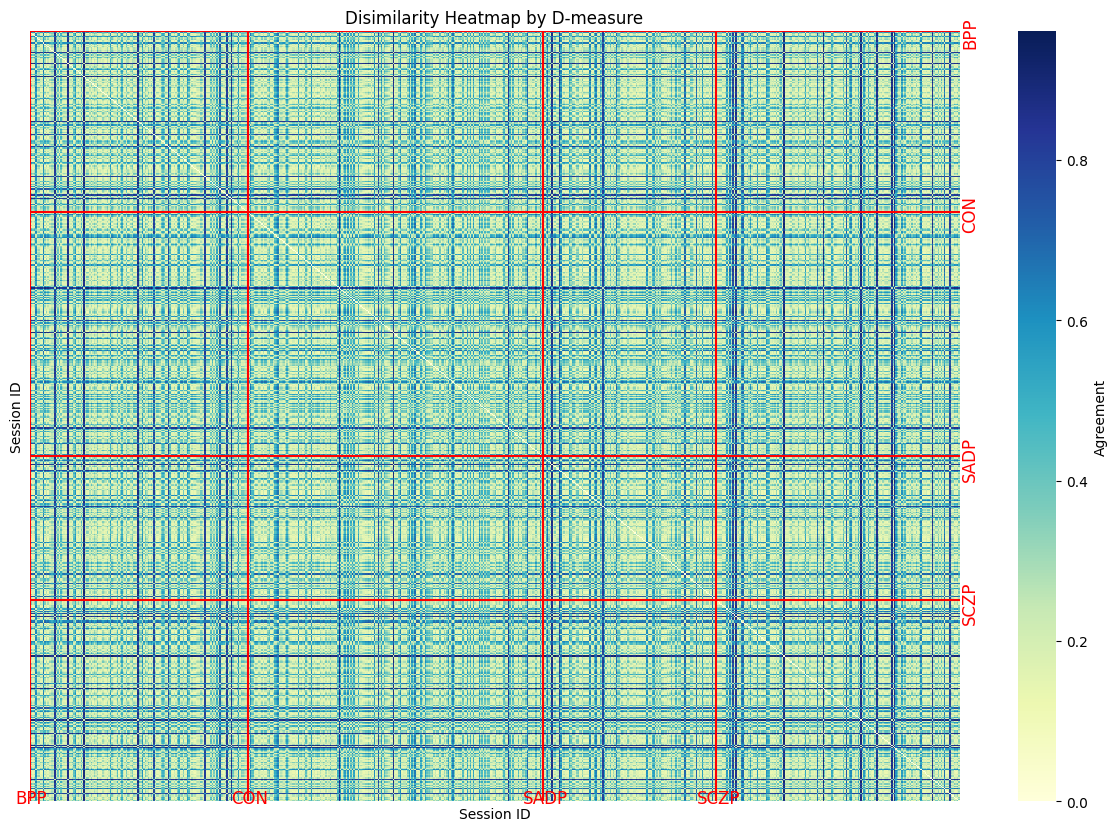

In [9]:
# Ensure all values in the similarity matrix are numerical
sorted_similarity_matrix = sorted_similarity_matrix.astype(float)

# Create a mapping from session ID to group for sorted sessions
groups = behavior_source.set_index('session_id')['Group'].to_dict()
sorted_sessions = sorted(session_ids, key=lambda x: groups[x])
sorted_groups = [groups[session] for session in sorted_sessions]

# Function to plot the heatmap with group boundaries
def plot_heatmap_with_groups(matrix, title):
    plt.figure(figsize=(15, 10))
    ax = sns.heatmap(matrix, cmap="YlGnBu", cbar_kws={'label': 'Agreement'}, xticklabels=False, yticklabels=False)

    # Add group boundaries
    boundary_indices = []
    current_group = sorted_groups[0]
    boundary_indices.append(0)  # Add the first boundary for the first group
    
    for idx, group in enumerate(sorted_groups):
        if group != current_group:
            boundary_indices.append(idx)
            current_group = group

    for boundary in boundary_indices:
        ax.axhline(boundary, color='red', linewidth=1.5)
        ax.axvline(boundary, color='red', linewidth=1.5)
    
    # Adding labels for group sections
    unique_groups = sorted(set(sorted_groups), key=sorted_groups.index)
    for boundary, group in zip(boundary_indices, unique_groups):
        ax.text(boundary + len(group)//2, len(matrix) + 1, group, horizontalalignment='center', fontsize=12, color='red')
        ax.text(len(matrix) + 1, boundary + len(group)//2, group, verticalalignment='center', fontsize=12, color='red', rotation=90)
    
    plt.title(title)
    plt.xlabel("Session ID")
    plt.ylabel("Session ID")
    plt.savefig(title.replace(" ", "_")+'.pdf', format='pdf')
    plt.show()

# Plot arithmetic agreement heatmap
plot_heatmap_with_groups(sorted_similarity_matrix, "Disimilarity Heatmap by D-measure")